In [1]:
# Importing the required modules

In [2]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [4]:
# Importing the dataset
df = pd.read_csv('Cleaned_Soil.csv')

In [5]:
# Obtaining data specific to Anantapur

In [6]:
df = df[df['District'] == 'Kurnool']
df.head()

,Unnamed: 0,Latitude,Longitude,District,Mandal,Village,SoilType,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI,ARVI,EVI,GCI,NDWI,Crop
1700,1702,15.34,78.32,Kurnool,Banaganpalli,Applapuram,Black,8.62,0.98,0.37,4.10,192.0,7280.0,878.0,58.30,0.43,2.71,13.79,1.04,7.36,0.625925,0.434195,1.698753,2.700348,-0.574500,Chickpea
1701,1703,15.34,78.32,Kurnool,Banaganpalli,Applapuram,Black,8.22,0.31,0.32,5.46,212.0,9156.0,1006.0,4.54,0.40,0.93,13.81,1.29,19.02,0.625925,0.434195,1.698753,2.700348,-0.574500,Chickpea
1702,1704,15.33,78.32,Kurnool,Banaganpalli,Applapuram,Black,8.27,0.41,0.42,9.21,299.0,8995.0,1454.0,13.67,0.40,1.14,13.79,1.27,25.99,0.515956,0.315495,1.404520,1.939759,-0.492355,Chickpea
1703,1705,15.34,78.31,Kurnool,Banaganpalli,Applapuram,Black,8.63,0.23,0.42,4.11,196.0,7970.0,1164.0,3.45,0.44,1.02,12.29,1.03,8.57,0.449421,0.259634,1.428429,1.551268,-0.436821,Pigeonpea
1704,1706,15.34,78.32,Kurnool,Banaganpalli,Applapuram,Black,8.56,0.34,0.22,4.27,200.0,8759.0,1283.0,3.18,0.38,1.16,10.87,1.12,18.94,0.625925,0.434195,1.698753,2.700348,-0.574500,Jowar


In [7]:
# Dropping unnecessary columns
df = df.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'District', 'Mandal', 'Village', 'ARVI', 'EVI', 'NDVI', 'NDWI'], axis = 1)
df.describe()

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,GCI
count,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.00000,419.000000
mean,8.078878,0.503532,0.340931,13.386945,147.482100,4108.384248,609.341289,37.721599,0.590931,1.223532,8.589714,1.034702,10.83031,1.901831
std,0.814803,1.165338,0.135438,12.331398,129.432554,3182.061509,535.419100,162.388020,0.592986,1.359873,5.699854,0.537233,5.70459,0.913850
min,5.210000,0.030000,0.060000,0.540000,23.000000,145.000000,27.000000,1.690000,0.130000,0.110000,0.740000,0.250000,1.40000,0.484642
25%,7.640000,0.180000,0.260000,4.680000,92.000000,995.000000,201.500000,5.160000,0.320000,0.485000,4.870000,0.680000,6.55500,1.273737
50%,8.300000,0.280000,0.330000,9.350000,133.000000,3474.000000,480.000000,8.450000,0.400000,0.860000,7.320000,0.950000,9.74000,1.582888
75%,8.680000,0.400000,0.410000,19.265000,181.000000,7279.000000,941.000000,18.085000,0.615000,1.400000,10.830000,1.210000,13.60500,2.095469
max,9.430000,16.950000,1.050000,109.090000,2409.000000,9538.000000,5363.000000,2539.580000,6.110000,13.730000,41.370000,3.440000,40.17000,4.490196


In [8]:
# Analysis of SoilType

In [9]:
df.SoilType.unique()

array(['Black', 'Nalla regadi', 'Red', 'Chowdu', 'Black & Red', 'Garuku',
       'Red ', 'Sowdu', 'Sudda', 'Thella kattu', 'Black & Mooru',
       'Chowdu +Nalla regadi', 'Sand+Ondu+White', 'Sudda Neela',
       'Sand +Ondu', 'Sand', 'Gurugu ', 'Tella masaka',
       'Chowdu + Nalla regadi', 'Nalla savudu', 'Regadi', 'Black, chowdu',
       'Chowdu+ Nalla regadi', 'Chowdu+ Red', 'Chowdu +Black',
       'Erra maska', 'Nalla regadi + chowdu', 'Sand +Chowdu',
       'Chowdu Sudda', 'Black + Chowdu', 'Chowdu + Black', 'sand', 'red',
       'Alkhaline'], dtype=object)

In [10]:
df['SoilType'] = df['SoilType'].replace(['Red', 'red', 'Chowdu+ Red', 'Red '], 'Red Soil')
df['SoilType'] = df['SoilType'].replace(['Black', 'Black, chowdu', 'Black + Chowdu', 'Black & Mooru'], 'Black Soil')
df = df[(df['SoilType'] == 'Red Soil') | (df['SoilType'] == 'Black Soil')]

In [11]:
soilCount = dict(df['SoilType'].value_counts())
for i in soilCount.keys():
    if i not in ['Red Soil', 'Black Soil']:
        soilCount.pop(i)
soilCount

{'Black Soil': 152, 'Red Soil': 156}

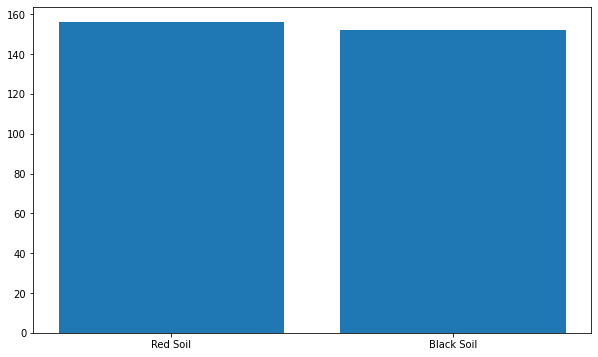

In [12]:
soilType = soilCount.keys()
soilCounts = soilCount.values()
plt.bar(soilType, soilCounts)
df = df.drop(['SoilType'], axis=1)

In [13]:
# Analysis of Crops grown 

In [14]:
df.Crop.unique()

array(['Chickpea', 'Pigeonpea', 'Jowar', 'Coriandam', 'Blackgram',
       'Bengalgram', 'Redgram', 'Cotton', 'Paddy', 'JOWAR', 'Paddy,jowar',
       'Fodder Crops', 'Dhanyalu', 'Jonna, Senaga', 'Senaga', 'Pogaku',
       'Mahendra Jonna', 'Merappa ; Senaga', 'Menumu', 'Pacha Jonna',
       'Jonna', 'Vari', 'Sunflower', 'Cottan', 'Ground Nat,Cottan',
       'Oniyan,Ground Nat', 'cotton', 'ground nut',
       'ground nut/groundnut', 'groundnut', 'Cottan,Ground Nat',
       'Grounat', 'Ground Nat', 'Cottan ,Groundnat', 'Cottan,',
       'Groundnut', 'Groundnut,Cottan', 'Ground nut,Cottan',
       'Cottan,Castral', 'GroundNut', 'Castor', 'GroundNut,Cotton',
       'Ground nut', 'Cotton,Vegitable', 'Ground nut,castor',
       'Ground nut ,Mirchi', 'Cotton,Ground Nut', 'Ground Nut',
       'Cotton,castor', 'Ground Nut, Cotton', 'Ground Nut,jowar',
       'Ground Nut ,Cotton', 'Clastor', 'Cotton,Groundnut'], dtype=object)

In [15]:
df['Crop'].value_counts()

Cotton                  82
Groundnut               43
Cottan                  16
Bengalgram              13
Jowar                   11
Senaga                  10
Ground Nut               9
Paddy                    9
Coriandam                8
Jonna                    8
GroundNut                7
Vari                     7
Sunflower                6
Mahendra Jonna           6
Ground Nat               5
Cottan,Ground Nat        5
Dhanyalu                 5
Redgram                  4
ground nut/groundnut     4
Blackgram                4
cotton                   4
Chickpea                 3
Paddy,jowar              2
Pacha Jonna              2
Clastor                  2
Cotton,Ground Nut        2
Ground nut,castor        2
Groundnut,Cottan         2
Ground Nut,jowar         2
Menumu                   1
Merappa ; Senaga         1
Ground Nut, Cotton       1
Grounat                  1
JOWAR                    1
ground nut               1
Pigeonpea                1
Ground Nut ,Cotton       1
C

GroundNut + Cotton    200
Jowar                  30
BengalGram             25
Coriander              13
Name: Crop, dtype: int64


<BarContainer object of 4 artists>

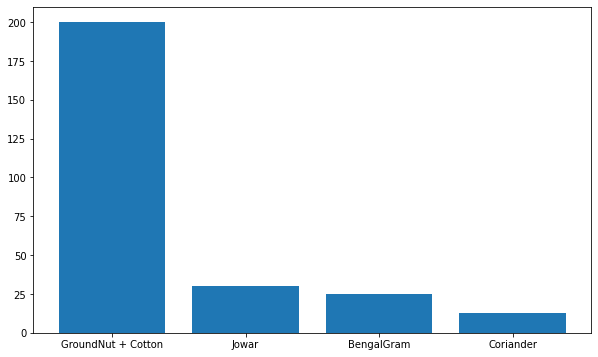

In [16]:
df['Crop'] = df['Crop'].replace('chill', 'Chilli')
df['Crop'] = df['Crop'].replace(['MAZI', 'maize', 'Mazi'], 'Maize')
df['Crop'] = df['Crop'].replace(['Bengalgram', 'Senaga', 'Merappa ; Senaga', 'Erra senaga', 'Jonna, Senaga', 'Jonna/Senaga'], 'BengalGram')
df['Crop'] = df['Crop'].replace(['jowar', 'Jowar', 'JOWAR', 'Jonna', 'Mahendra Jonna', 'Pacha Jonna', 'Erra Jonna', 'Veru senaga, Jonna', 'Jonna+ sunflower', 'Paddy,jowar'],'Jowar')
df['Crop'] = df['Crop'].replace('Vari','BarnyardMillet')
df['Crop'] = df['Crop'].replace(['Dhanyalu', 'Coriandam', 'Dhanyalu , Jonnalu'], 'Coriander')
df['Crop'] = df['Crop'].replace(['Oniyan,Ground Nat', 'ground nut', 'ground nut/groundnut', 'groundnut', 'Grounat', 'Ground Nat', 'Groundnut', 'GroundNut', 'Ground nut', 'Ground nut,castor', 'Ground nut ,Mirchi', 'Ground Nut', 'Ground Nut,jowar'],'GroundNut')
df['Crop'] = df['Crop'].replace(['Cottan', 'cotton', 'Cottan,', 'Cottan,Castral', 'Cotton,Vegitable', 'Cotton,castor'],'Cotton')
df['Crop'] = df['Crop'].replace(['Ground Nat,Cottan', 'Cottan,Ground Nat', 'Cottan ,Groundnat', 'Groundnut,Cottan', 'Ground nut,Cottan', 'GroundNut,Cotton', 'Cotton,Ground Nut', 'Ground Nut, Cotton', 'Ground Nut ,Cotton', 'Cotton,Groundnut', 'Cotton', 'GroundNut'], 'GroundNut + Cotton')
df = df[(df['Crop'] != 'Clastor') & (df['Crop'] != 'Castor') & (df['Crop'] != 'Onian') & (df['Crop'] != 'Korra, Maagu') & (df['Crop'] != 'Menumu') & (df['Crop'] != 'Peasara + Pacha Gaddi')]
df = df[(df['Crop'] != 'Chickpea') & (df['Crop'] != 'Pigeonpea') & (df['Crop'] != 'Blackgram') & (df['Crop'] != 'Redgram') & (df['Crop'] != 'Fodder Crops') & (df['Crop'] != 'Pogaku')]
df = df[(df['Crop'] != 'Sunflower') & (df['Crop'] != 'Paddy') & (df['Crop'] != 'BarnyardMillet')]

print(df['Crop'].value_counts())
cropCount = dict(df['Crop'].value_counts())
cropType = cropCount.keys()
cropCounts = cropCount.values()
plt.bar(cropType, cropCounts)

In [17]:
# Getting rid of features that have a high correlation among one another

In [18]:
cor_matrix = df.corr()
cor_matrix

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,GCI
pH,1.000000,0.154452,0.143359,-0.396558,0.348434,0.626301,0.642893,0.074972,-0.126218,0.371529,-0.279575,0.103744,-0.426539,-0.074567
EC,0.154452,1.000000,0.046686,-0.090044,0.137063,0.171919,0.156968,0.898053,-0.009671,0.760777,-0.011341,0.054006,-0.050767,0.011551
OC,0.143359,0.046686,1.000000,0.354102,0.602425,0.190425,0.240549,0.025472,0.320512,0.154228,0.095769,0.462408,0.264084,-0.078548
P,-0.396558,-0.090044,0.354102,1.000000,0.082333,-0.508645,-0.382889,-0.064294,0.469405,-0.227254,-0.046002,-0.003312,0.186107,0.034347
K,0.348434,0.137063,0.602425,0.082333,1.000000,0.523478,0.526675,0.077524,0.152489,0.333931,0.255874,0.406623,0.190940,-0.076007
Ca,0.626301,0.171919,0.190425,-0.508645,0.523478,1.000000,0.909771,0.137600,-0.178579,0.484745,0.301247,0.380660,0.003488,-0.019428
Mg,0.642893,0.156968,0.240549,-0.382889,0.526675,0.909771,1.000000,0.128820,-0.058152,0.528310,0.230898,0.459196,0.021749,-0.045249
S,0.074972,0.898053,0.025472,-0.064294,0.077524,0.137600,0.128820,1.000000,0.002534,0.762968,0.000587,0.048406,-0.015404,0.017240
Zn,-0.126218,-0.009671,0.320512,0.469405,0.152489,-0.178579,-0.058152,0.002534,1.000000,0.034307,-0.068955,0.273181,0.216550,0.051308
B,0.371529,0.760777,0.154228,-0.227254,0.333931,0.484745,0.528310,0.762968,0.034307,1.000000,0.073986,0.261500,-0.028932,-0.006766


In [19]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
print('Columns to be dropped : ', to_drop)

Columns to be dropped :  ['K', 'Ca', 'Mg', 'S', 'B', 'Mn']


In [20]:
df = df.drop(to_drop, axis = 1)
print('Columns taken into consideration : ', list(df.columns))

Columns taken into consideration :  ['pH', 'EC', 'OC', 'P', 'Zn', 'Fe', 'Cu', 'GCI', 'Crop']


In [21]:
# Separating the dependent and independent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [22]:
# Encoding SoilType as it is a categorical variable
X = pd.get_dummies(X, prefix='', prefix_sep='')
print(X.head(1))
print(y.head(1))
X = X.values
y = y.values

        pH    EC    OC     P    Zn     Fe    Cu       GCI
1704  8.56  0.34  0.22  4.27  0.38  10.87  1.12  2.700348
1704    Jowar
Name: Crop, dtype: object


In [23]:
# Standardizing the independent variables using Feature Scaling
sc1 = StandardScaler()
X[:, :] = sc1.fit_transform(X[:, :])

In [24]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# K-Nearest Neighbors Classifier

In [25]:
clf1 = KNeighborsClassifier(weights='distance')
clf1.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [26]:
y_test_pred = clf1.predict(X_test)
y_train_pred = clf1.predict(X_train)
AC1_train = accuracy_score(y_train, y_train_pred)
AC1_test = accuracy_score(y_test, y_test_pred)

In [27]:
print('Training Accuracy: ', AC1_train)
print('Testing Accuracy: ', AC1_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7910447761194029


In [28]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf1, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 74.62 %
Standard Deviation: 4.18 %


# Decision Tree Classifier

In [29]:
clf2 = DecisionTreeClassifier(random_state=0)
clf2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [30]:
y_test_pred = clf2.predict(X_test)
y_train_pred = clf2.predict(X_train)
AC2_train = accuracy_score(y_train, y_train_pred)
AC2_test = accuracy_score(y_test, y_test_pred)

In [31]:
print('Training Accuracy: ', AC2_train)
print('Testing Accuracy: ', AC2_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7313432835820896


In [32]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf2, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 72.67 %
Standard Deviation: 4.90 %


# Random Forest Classifier

In [33]:
clf3 = RandomForestClassifier(random_state=0)
clf3.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [34]:
y_test_pred = clf3.predict(X_test)
y_train_pred = clf3.predict(X_train)
AC3_train = accuracy_score(y_train, y_train_pred)
AC3_test = accuracy_score(y_test, y_test_pred)

In [35]:
print('Training Accuracy: ', AC3_train)
print('Testing Accuracy: ', AC3_test)

Training Accuracy:  1.0
Testing Accuracy:  0.8059701492537313


In [36]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf3, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 78.12 %
Standard Deviation: 3.23 %


# XGBoost

In [37]:
clf4 = HistGradientBoostingClassifier(random_state=0)
clf4.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=0)

In [38]:
y_test_pred = clf4.predict(X_test)
y_train_pred = clf4.predict(X_train)
AC4_train = accuracy_score(y_train, y_train_pred)
AC4_test = accuracy_score(y_test, y_test_pred)

In [39]:
print('Training Accuracy: ', AC4_train)
print('Testing Accuracy: ', AC4_test)

Training Accuracy:  1.0
Testing Accuracy:  0.8208955223880597


In [40]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf4, X = X_train, y = y_train, cv = 10)

In [41]:
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 76.14 %
Standard Deviation: 3.53 %


In [42]:
pickle.dump(clf4, open('Kurnool_model.pkl', 'wb'))
pickle.dump(sc1, open('Kurnool_scaler.pkl', 'wb'))

# Multi-layer Perceptron Classifier

In [43]:
clf5 = MLPClassifier(random_state=0, learning_rate= 'adaptive')
clf5.fit(X_train, y_train)

MLPClassifier(learning_rate='adaptive', random_state=0)

In [44]:
y_test_pred = clf5.predict(X_test)
y_train_pred = clf5.predict(X_train)
AC5_train = accuracy_score(y_train, y_train_pred)
AC5_test = accuracy_score(y_test, y_test_pred)

In [45]:
print('Training Accuracy: ', AC5_train)
print('Testing Accuracy: ', AC5_test)

Training Accuracy:  0.8258706467661692
Testing Accuracy:  0.7761194029850746


In [46]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf5, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 81.07 %
Standard Deviation: 3.10 %


# Catboost

In [47]:
from catboost import CatBoostClassifier, Pool, cv

model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

model.calc_feature_statistics(X_train, y_train, feature=1, plot=True)

train_data = Pool(data=X_train, label=y_train)
model.get_feature_importance(train_data)

#Cross-Validation
cv_dataset = Pool(data=X_train, label=y_train)
params = {"iterations": 100, "depth": 2, "loss_function": "MultiClass", "verbose": False}
scores = cv(cv_dataset, params, fold_count=5, plot="True")

model = CatBoostClassifier(loss_function='MultiClass')
grid = {'learning_rate': [0.03, 0.1], 'depth': [4, 6, 10]}
grid_search_result = model.grid_search(grid, X=X_train, y=y_train, cv=3, plot=True)

model.score(X_test, y_test)

# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

0:	learn: 0.8213635	total: 47ms	remaining: 4.66s
1:	learn: 0.5760471	total: 48ms	remaining: 2.35s
2:	learn: 0.5285704	total: 48.5ms	remaining: 1.57s
3:	learn: 0.4900084	total: 49.1ms	remaining: 1.18s
4:	learn: 0.4536235	total: 49.7ms	remaining: 945ms
5:	learn: 0.4231809	total: 50.3ms	remaining: 788ms
6:	learn: 0.4078674	total: 50.9ms	remaining: 676ms
7:	learn: 0.3957746	total: 51.5ms	remaining: 592ms
8:	learn: 0.3922825	total: 52ms	remaining: 526ms
9:	learn: 0.3626374	total: 52.6ms	remaining: 473ms
10:	learn: 0.3463315	total: 53.3ms	remaining: 431ms
11:	learn: 0.3371259	total: 53.8ms	remaining: 395ms
12:	learn: 0.3334191	total: 54.4ms	remaining: 364ms
13:	learn: 0.3194134	total: 55ms	remaining: 338ms
14:	learn: 0.3111243	total: 55.6ms	remaining: 315ms
15:	learn: 0.3081597	total: 56.2ms	remaining: 295ms
16:	learn: 0.2972156	total: 57.5ms	remaining: 281ms
17:	learn: 0.2894935	total: 58.2ms	remaining: 265ms
18:	learn: 0.2865928	total: 60.6ms	remaining: 258ms
19:	learn: 0.2842079	total: 61

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.6294676982
bestIteration = 99

Training on fold [1/5]

bestTest = 0.6084824507
bestIteration = 99

Training on fold [2/5]

bestTest = 0.5954669673
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5590814649
bestIteration = 99

Training on fold [4/5]

bestTest = 0.6062793357
bestIteration = 99



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
2:	learn: 1.2757369	total: 3.33ms	remaining: 1.11s
3:	learn: 1.2498009	total: 4.5ms	remaining: 1.12s
4:	learn: 1.2164443	total: 5.56ms	remaining: 1.11s
5:	learn: 1.1837664	total: 6.61ms	remaining: 1.09s
6:	learn: 1.1592970	total: 7.68ms	remaining: 1.09s
7:	learn: 1.1354466	total: 8.76ms	remaining: 1.09s
8:	learn: 1.1075959	total: 9.83ms	remaining: 1.08s
9:	learn: 1.0887912	total: 11ms	remaining: 1.09s
10:	learn: 1.0694450	total: 12.1ms	remaining: 1.08s
11:	learn: 1.0457482	total: 13.1ms	remaining: 1.08s
12:	learn: 1.0258877	total: 14.3ms	remaining: 1.08s
13:	learn: 1.0065314	total: 15.5ms	remaining: 1.09s
14:	learn: 0.9867943	total: 16.6ms	remaining: 1.09s
15:	learn: 0.9694609	total: 17.7ms	remaining: 1.09s
16:	learn: 0.9524165	total: 18.8ms	remaining: 1.09s
17:	learn: 0.9350823	total: 19.9ms	remaining: 1.08s
18:	learn: 0.9208275	total: 20.9ms	remaining: 1.08s
19:	learn: 0.9051131	total: 22ms	remaining: 1.08s
20:	learn: 0.8899525	total